<a href="https://colab.research.google.com/github/noobylub/Computational-Linguistic/blob/master/SmallAttentionBasedLM_(with_TODOs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will implement a small decoder-only Transformer.

In [ ]:
import math
import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader

from transformers import AutoModel, AutoTokenizer

First let's see how we can look inside pretrained (or simply preconfigured) models to see what components they have.

In [ ]:
t5 = AutoModel.from_pretrained('google/t5-efficient-tiny')

In [ ]:
t5

In [ ]:
t5.encoder

In [ ]:
gpt2 = AutoModel.from_pretrained('gpt2')
gpt2

In [ ]:
# Lexical embeddings
gpt2.wte

In [ ]:
# Positional embeddings
gpt2.wpe

In [ ]:
# Transformer layers
gpt2.h[0]

In [ ]:
bert = AutoModel.from_pretrained('google-bert/bert-base-cased')

In [ ]:
bert

In [ ]:
bert.embeddings

In [ ]:
bert.encoder.layer[0]

In [ ]:
# Some useful torch functions.
size = 5
full_matrix = torch.full(
    (size, size),  # we can also use full_like and put the target tensor here
    float("-inf")
)
full_matrix

In [ ]:
# torch.triu (upper triangular matrix) retains all elements above an on
# the diagonal and replaces all elements below the diagonal with zero.
# diagonal=1 means that we take 'second' diagonal, starting at [0, 1]
# as the boundary.
torch.triu(
    full_matrix,
    diagonal=1,
)

## The TODO list

If we do not try to implement the full Transformer architecture, which is a bit niche nowadays, we need the following components:

1. Lexical embeddings (in the usual case, a single matrix).
2. **Positional embeddings.** (Many options.)
3. **Self-attention.** (Many options.)
4. **Fully-connected sublayer.** (A choice of activation functions. Out of scope: mixture-of-experts.)
5. **Normalisation.**
6. Dropout (can use the standard implementation).
7. Residual connections (basically a couple of additions here and there).

### Attention

Let's implement the standard single-head self-attention. Phuong and Hutter describe it in the following way: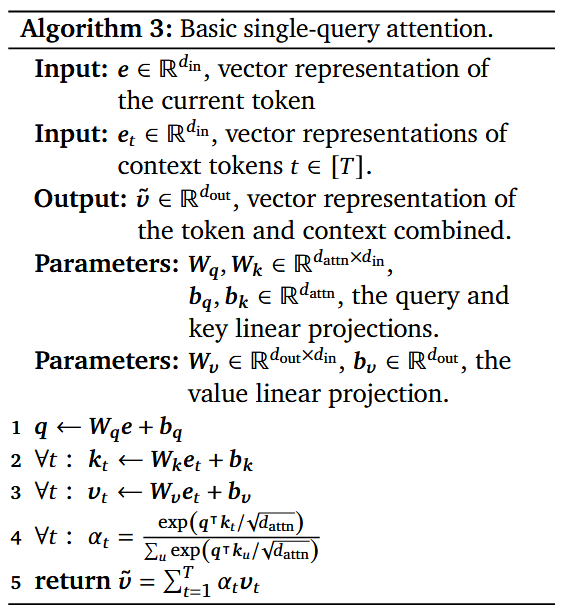

We will compute values for all tokens in the sequence in one go (so that we can use efficient matrix multiplications instead of looping), and we will add masking, so that we can use it both for encoders and decoders.

In [ ]:
class Attention(nn.Module):
    """
    Simple single-head soft attention.
    """
    def __init__(self, input_dim, q_dim):
        super().__init__()
        self.q_dim = q_dim
        # nn.Linear is automatically initialised and includes bias already
        self.query_projection = nn.Linear(input_dim, q_dim)
        # Should have the same output dimensionality as the query projection
        self.key_projection = nn.Linear(input_dim, q_dim)
        self.value_projection = nn.Linear(input_dim, input_dim)

    def forward(self, X, causal_masking=True):
        """
        For simplicity we assume that we are training on a single sequence
        at a time, so the input shape is (sequence_length, input_dim).

        What will we need to do to handle padding tokens in the input?
        """
        # (sequence_length, q_dim)
        Q = None
        K = None
        # (sequence_length, input_dim)
        V = None
        # (sequence_length, sequence_length)
        # We need to transpose the keys for multiplication,
        # but we cannot use K.T because the first dimension is
        # the batch dimension, and we need to keep it, so
        # we specify dimensions explicitly.
        scores = Q @ K.transpose(-2, -1)

        # Normalisation
        # TODO

        # When doing autoregressive language modelling, we do not allow
        # tokens to attend to tokens on the right because this gives away the
        # answer. A simple way to do this is to ensure that the softmax scores
        # for tokens to the right of the target token are always zero. In order
        # to insure that, we can replace the corresponding attention scores with
        # negative infinity, so that exp(score) = 0.
        if causal_masking:
            # TODO
            pass

        attention_weights = None
        return None

Now we can combine values of elements in the sequence based on their `relevance' to the target element, with or without causal masking. What important piece of information are we still missing? (Think of elements in the sequence as words, for example.)

### Positional embeddings

The original Transformer paper converted each positional index into a vector of length $d_e$ (model dimension). They use the following formula:

$$ \mathbb{e}_{t,i} =
\begin{cases}
    \cos\left(\dfrac{t}{l_{\text{max}}^{(i-1)/d_e}}\right),& \text{if i is odd}\\
    \sin\left(\dfrac{t}{l_{\text{max}}^{i/d_e}}\right),              & \text{otherwise}
\end{cases}
$$

for $0 \le i < d_e$; $l_{\text{max}}$ is a fixed constant, originally 10000. Note that odd $i$'s are shifted by one, so we in fact are using the sequence of even indices twice.

In [ ]:
class PositionalEmbeddingSinCos(nn.Module):
    """
    Classic sinusoidal positional embeddings (Vaswani et al., 2017).

    Adds fixed (non-trainable) position-dependent vectors to token embeddings.
    """

    def __init__(self, d_model: int, max_len: int = 512):
        """
        Args:
            d_model: Embedding dimension
            max_len: Maximum supported sequence length
        """
        super().__init__()

        # Create matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)

        # Position indices: (max_len, 1)
        position = torch.arange(0, max_len).unsqueeze(1)

        # Compute denominator term, i.e. things multiplied by t's.
        # To be on the safe side, we don't want to do 10000 ** x,
        # so we perform the calculation in the log-space first.
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        # Apply sine to even indices (t's)
        pe[:, 0::2] = torch.sin(position * div_term)

        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Shape: (1, max_len, d_model) for broadcasting
        pe = pe.unsqueeze(0)

        # Register as buffer (not trainable, saved with model)
        # Computed once at initialisation, then reused
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Input embeddings of shape (batch, seq_len, d_model)

        Returns:
            Positionally enriched embeddings
        """
        # TODO
        result = None
        return result


Deterministic positional embeddings were designed to make it easier for the models to understand both absolute positions and distances between positions. However, there is no guarantee that using sines and cosines is the optimal way to do it, and an obvious alternative is to let the model learn positional embeddings itself. This was the strategy used in BERT and RoBERTa.

When using learned positional embeddings, we run into subtle issues with padding tokens: we must make absolutely sure that they never participate in the loss computation and that gradients do not flow through them. In order to safeguard against this, we always keep them zeroed out, i.e. give them a zero positional embedding as well.

One may ask why bother with deterministic positional embedding at all, but they made quite a comeback in the guise of RoPE, which we'll see later.

In [ ]:
class LearnedPositionalEmbedding(nn.Module):
    """
    Minimal learned positional embeddings (RoBERTa/BERT style).

    - Uses an nn.Embedding table for positions.
    - Supports padding via `padding_idx` (positions for pad tokens get 0 vector).
    - Adds position embeddings to token embeddings.
    """

    def __init__(self, d_model: int, max_len: int = 514, padding_idx: int = 1):
        """
        Args:
            d_model: hidden size
            max_len: max sequence length supported (often 512 + 2 specials)
            padding_idx: index in input_ids used for padding (RoBERTa typically 1)
        """
        super().__init__()
        self.max_len = max_len
        self.padding_idx = padding_idx
        self.position_embeddings = nn.Embedding(max_len, d_model, padding_idx=0)

        # We'll map pad positions to index 0 in the position table.
        # (i.e., row 0 stays zeroed and is never updated)
        with torch.no_grad():
            self.position_embeddings.weight[0].zero_()

    def forward(self, x: torch.Tensor, input_ids: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: token embeddings, shape (batch, seq_len, d_model)
            input_ids: token ids, shape (batch, seq_len)

        Returns:
            x + learned position embeddings, same shape as x
        """
        bsz, seq_len, d_model = x.shape
        if seq_len > self.max_len:
            raise ValueError(f"seq_len={seq_len} exceeds max_len={self.max_len}")

        device = x.device

        # RoBERTa-style: positions start at padding_idx+1 for non-pad tokens,
        # and pad tokens get position id 0 (so embedding is zero).
        position_ids = None

        pos_emb = self.position_embeddings(position_ids)           # (B, T, D)
        # Additive encoding
        return None


### Normalisation

Now we will implement the so-called LayerNorm. Despite its name, it does not normalise the inputs across the whole layer or sequence but normalises each token embedding across the model dimension. (For inputs of other types, such as images, LayerNorm can be defined differently. The crucial point is that there is no normalisation across inputs, as in BatchNorm; BatchNorm is awkward in NLP because inputs are sequences and features are not aligned.)

LayerNorm uses a couple of trainable parameter vectors, because why not:

$$y = \dfrac{x - \bar{x}}{\sqrt{\text{Var}[x] + ϵ}} \times \gamma + \beta$$

In [ ]:
class LayerNorm(nn.Module):
    """
    BERT-style LayerNorm: normalise over last dimension with learnable
    scale (gamma) and bias (beta).
    """

    def __init__(self, hidden_size: int, eps: float = 1e-12):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(hidden_size))   # gamma
        self.bias = nn.Parameter(torch.zeros(hidden_size))    # beta

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (..., hidden_size)
        result = None
        return result


### Feedforward sublayer

Attention is fundamentally a linear operation. Even though the weights
are computed using softmax, which isn't linear, in the end we take a linear
combination of linear projections of the inputs. Since linear combinations
are sums, and summation is commutative, we
    
1. don't know the order of the inputs and
2. can generate outputs in any order (or in parallel, as we do above).

All this makes processing very fast (or as fast as we can multiply
matrices), but for best results we should (arguably https://linear-transformers.com/) add non-linearities somewhere.

RNNs have non-linearities between sequential tokens. This makes them very
slow and hard to train. Transformers instead encode linear order either
in the inputs themselves (absolute positional embeddings, see below) or in
the attention mechanism (relative positional embeddings, a topic for a
future class). Non-linearities only surface between layers: after we combine
inputs linearly using attention, we pass the result through an MLP,
position-wise. Here we can experiment with activation functions. We will use
ReLU for now.

In [ ]:
class MLP(nn.Module):
    """
    Just an MLP, applied elementwise over the last dimension.
    """
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        # TODO

    def forward(self, X):
        result = None
        return result

### A full layer

Now we have all the components and we only need to chain them together in a correct way.

In [ ]:
class TransformerLayer(nn.Module):
    """
    Transformer layers do not change the shape of the input, so we can
    arbitrarily stack them.

    Transformer layer consist of sublayers and residual connection. A popular
    sequence looks like this:

    1. LayerNorm #1
    2. Attention
    3. Residual connection #1
    4. LayerNorm #2
    5. MLP
    6. Residual connection #2
    """
    def __init__(self, input_dim, query_dim, mlp_hidden_dim, dropout_p=0.1):
        super().__init__()

        # TODO

    def forward(self, X, causal_masking=True):
        result = None
        return result

In [ ]:
class LexicalEmbedding(nn.Module):
    """
    A simple wrapper around nn.Embedding, which takes special care to
    handle padding tokens.
    """
    def __init__(self, vocab_size, input_dim, padding_idx):
        super().__init__()
        self.emb = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=input_dim,
            padding_idx=padding_idx,
        )

    def forward(self, x: torch.Tensor):
        """
        This will accept both single and batched inputs.
        """
        return self.emb(x.long())  # (..., D)

To save on tokenisation, we will first build a byte-based model: a generalisation of character-based models that works directly with underlying encoding, which today meants UTF-8.

In this way, we get a small vocabulary (each byte is a value between 0 and 255) and don't have to think about what a character is. Well, actually we still have to, but at the stage of preprocessing, not tokenisation; see https://langsci-press.org/catalog/book/176 for details.

All ASCII characters map to single bytes, so working with English is very easy.

Note that we still need `lexical' embeddings.

In [ ]:
# Converting strings to integers
# 1. Convert to bytes using .encode().
# 2. Convert bytes to int.
bytes_1 = 'Hello, Torch'.encode()
print(f'{bytes_1=}, ({len(bytes_1)} bytes)')
input_1 = list(map(int, bytes_1))

bytes_2 = 'こんにちは、PyTorch。'.encode()
print(f'{bytes_2=}, ({len(bytes_2)} bytes)')
input_2 = list(map(int, bytes_2))

In [ ]:
print(bytes(input_2).decode())

In [ ]:
def byte_tokenise(inputs):
    if type(inputs) == str:
        inputs = []

    input_bytes = list(map(
        lambda s: list(map(int, s.encode())),
        inputs
    ))
    # Add padding to make all inputs the same length.
    max_len = max(map(len, input_bytes))
    for i in range(len(input_bytes)):
        current_len = len(input_bytes[i])
        input_bytes[i] = input_bytes[i] + [0] * (max_len - current_len)

    return input_bytes

In [ ]:
greetings_bytes = byte_tokenise(['Hello', '你好', 'Привет'])
greetings_bytes

In [ ]:
import torch
from torch import nn

# Parameters for the dry run
vocab_size = 256     # For byte-based model
input_dim = 64       # Embedding dimension
max_len = 128        # Maximum sequence length
padding_idx = 0      # Dummy padding index
query_dim = 32       # Query dimension for attention
# Hidden dimension for the MLP; usually bigger than the hidden dimension
mlp_hidden_dim = 128
batch_size = 2
seq_len = 10

# 1. Lexical Embedding
print("Initializing LexicalEmbedding...")
lexical_embedding_layer = LexicalEmbedding(vocab_size, input_dim, padding_idx)

# Create dummy input_ids (batch_size, seq_len)
input_ids = torch.tensor(greetings_bytes)

print(f"Input IDs shape: {input_ids.shape}")
lexical_embeddings = lexical_embedding_layer(input_ids)
print(f"Lexical embeddings shape: {lexical_embeddings.shape}")

# 2. Positional Embedding (using SinCos for simplicity)
print("\nInitializing PositionalEmbeddingSinCos...")
positional_embedding_layer = PositionalEmbeddingSinCos(input_dim, max_len)

combined_embeddings = positional_embedding_layer(lexical_embeddings)
print(f"Combined (lexical + positional) embeddings shape: {combined_embeddings.shape}")

# 3. Transformer Layer
print("\nInitializing TransformerLayer...")
transformer_layer = TransformerLayer(input_dim, query_dim, mlp_hidden_dim)

# Pass through the transformer layer with causal masking
output_embeddings = transformer_layer(combined_embeddings, causal_masking=True)
print(f"Output embeddings shape after TransformerLayer: {output_embeddings.shape}")

In [ ]:
output_embeddings[0, -1]